<a href="https://colab.research.google.com/github/jong9810/TensorFlow-2.0/blob/main/12_4_Kaggle_Data_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Data를 활용한 예제3 : COVID-19 Radiography Data
- COVID 19, Viral Pneumonia, Lung Opacity, Normal 등 4가지 label에 대해 21,165개의 chest X-Ray 이미지 데이터를 포함하고 있다.

## 모델 아키텍쳐
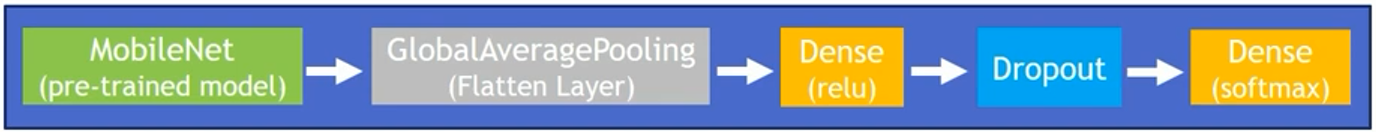

- 전이 학습을 이용하여 학습을 하였고 사전 학습 모델로는 MobildNet을 사용하였다.
- 오버피팅을 낮추고 정확도를 높이기 위해 출력층 전에 하나의 Dense layer을 추가하였다.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

tf.__version__

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
# 1. 데이터 다운로드
import os
import shutil

try:
    dataset_path = '/content/gdrive/My Drive/Colab Notebooks/dataset'
    shutil.copy(os.path.join(dataset_path, 'COVID-19_Radiography.zip'), '/content')

except Exception as err:
    print(str(err))

In [ ]:
# 2. 데이터 저장할 디렉토리 생성
ROOT_DIR = '/content'
DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'COVID-19_Radiography')
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [ ]:
if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)
    print(DATA_ROOT_DIR + ' is removed!!!')

In [ ]:
import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'COVID-19_Radiography.zip'), 'r') as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [ ]:
import glob

total_file_list = glob.glob(os.path.join(DATA_ROOT_DIR, 'COVID-19_Radiography_Dataset/*'))

# list comprehension : 리스트 안에 for, if 문 등을 이용하여 간단하게 리스트를 초기화하는 방법
# total_file_list의 원소 중 디렉토리인 것만 모아서, '/'를 기준으로 잘라서 가장 마지막 원소에서 공백을 제거하여 label_name_list 원소로 저장함 
label_name_list = [ file_name.split('/')[-1].strip() for file_name in total_file_list if os.path.isdir(file_name)==True ]

for label_name in label_name_list: # 각각의 정답에 대해 반복
    src_dir_path = os.path.join(DATA_ROOT_DIR, 'COVID-19_Radiography_Dataset'+'/'+label_name+'/images')
    dst_dir_path = os.path.join(DATA_ROOT_DIR, 'train/'+label_name)

    try:
        # shutil.coptyree 이용해서 원본 데이터와 동일한 정답을 가지는 train 디렉토리를 생성하고 원본 이미지 복사
        shutil.copytree(src_dir_path, dst_dir_path)
    
    except Exception as err:
        print(str(err))
    
if not os.path.exists(TEST_DATA_ROOT_DIR):
    os.mkdir(TEST_DATA_ROOT_DIR)

for label_name in label_name_list:
    # Test 디렉토리에 label 이름을 가진 폴더가 있는지 확인하고 없으면 각각의 label의 이름을 가지는 폴더를 Test 디렉토리에 생성
    if not os.path.exists(os.path.join(TEST_DATA_ROOT_DIR, label_name)):
        os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))

In [ ]:
# 3. 데이터 전처리
# 테스트 데이터 생성
import random

MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    train_data_file_list = os.listdir(src_dir_path)
    random.shuffle(train_data_file_list)

    split_num = int(MOVE_RATIO * len(train_data_file_list))
    test_data_file_list = train_data_file_list[0:split_num]

    for test_data_file in test_data_file_list:
        try:
            shutil.move(os.path.join(src_dir_path, test_data_file), 
                        os.path.join(dst_dir_path, test_data_file))
        
        except Exception as err:
            print(str(err))

In [ ]:
# 4. 이미지 데이터 불러오기 (ImageDataGenerator, flow_from_directory() 사용)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32, 
                                                    color_mode='rgb', class_mode='sparse', 
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                    subset='training')

validation_generator = validation_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32, 
                                                    color_mode='rgb', class_mode='sparse', 
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                    subset='validation')

test_generator = test_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=32, 
                                                    color_mode='rgb', class_mode='sparse', 
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT))

In [ ]:
print(train_generator.class_indices)
print(train_generator.num_classes)

In [ ]:
# print(train_generator[0])

In [ ]:
# 데이터 시각화 (training  data 랜덤하게 16개)
IMG_NUMS = 16

image_data, label_data = train_generator.next()

data = image_data[:IMG_NUMS]
label = label_data[:IMG_NUMS]

In [ ]:
class_dict = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

plt.figure(figsize=(9,9))
for i in range(len(label)):
    plt.subplot(4,4,i+1)
    plt.title(str(class_dict[label[i]]))
    plt.xticks([]); plt.yticks([])

    plt.imshow(data[i])

plt.tight_layout()
plt.show()

In [ ]:
 from tensorflow.keras.models import Sequential
 from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
 from tensorflow.keras.applications import MobileNet
 from tensorflow.keras.optimizers import Adam
 from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 5. 모델 구축
class_nums = train_generator.num_classes

pre_trained_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(class_nums, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(2e-5), metrics=['acc'])
model.summary()

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
hist = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[earlystopping])

In [ ]:
model.evaluate(test_generator)

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')

plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
# # 6. 예측 & 정답과 비교
# IMG_NUMS = 16

# image_data, label_data = train_generator.next()

# data = image_data[:IMG_NUMS]
# label = label_data[:IMG_NUMS]

# pred = model.predict(train_generator[:16])

In [ ]:
# class_dict = {0: 'COVID', 1: 'Lung_Opacity', 2: 'Normal', 3: 'Viral Pneumonia'}

# plt.figure(figsize=(9,9))
# for i in range(len(label)):
#     plt.subplot(4,4,i+1)
#     plt.title('label: ' + str(class_dict[label[i]]) + '\npred : ' + )
#     plt.xticks([]); plt.yticks([])

#     plt.imshow(data[i])

# plt.tight_layout()
# plt.show()